# Resultados preliminares: ajuste de modelos dinámicos a mediciones de potencial de membrana bajo current clamp

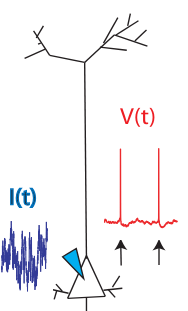


Para esta entrega preliminar, desarrollamos un módulo que implementa los modelos LIF y AdEx como clases, con los método necesarios para fijar parámetros, simular, y ajustar a una medición minimizando la diferencia en las tasas de disparo. A partir de este módulo, vamos a aproximar una señal de voltaje de membrana de neurona única bajo clampeo de corriente.

Los datos utilizados forman parte de una competencia de neuroscience CRNCS 2009, para mas informacion acerca del ejercicio la consigna se encuentra en el siguiente link https://crcns.org/files/data/ch-epfl-2009/crcns-ch-epfl-2009-instructions.pdf. En nuestro caso nosotros desarollaremos el ejercicio A del mismo, que consiste en entrenar un modelo de célula única a mediciones reales.

Se nos otorgan dos archivos Uno contiene datos sobre la corriente inyectada a una neurona y el otro contiene datos sobre su respuesta a la corriente. El ensayo esta separado en dos partes una de entrenamiento que consta de los primeros 16 segundos y otra de prueba que se trata de los restantes 44 segundos. Durante los primeros 16 segundos se inyecta 4 corrientes de tipo pulso cuadrado y luego de ese tiempo se deja ruido blanco.

La data de la tension medida solo llega hasta los 40 segundos y nuestra labor es predecir como seran los disparos de neuronas en el tiempo restante.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
# Paquete de modelos de neuronas
from neuron_models.utils import *
# Importamos los modelos
from neuron_models.adex import Adex_model
from neuron_models.lif import LIF_model

In [2]:
%load_ext autoreload
%autoreload 2

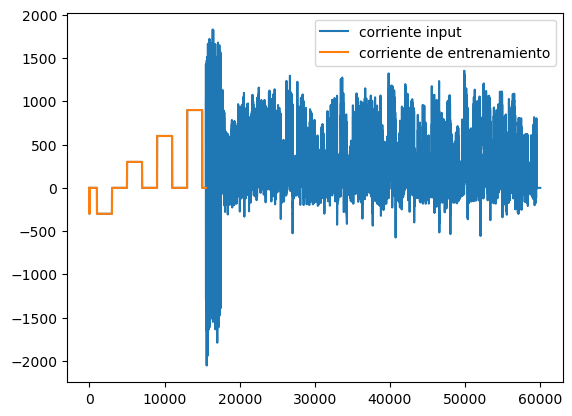

In [3]:
# Leemos la corriente
corrientes = r"dataset/current.txt"
data = np.loadtxt(corrientes, delimiter=',')
I_data= np.loadtxt(corrientes, delimiter=',')*pA

t_max = 60*1e3*ms
train_end_t = 155000
fs = len(I_data-1)/t_max
t_total = np.arange(0, t_max, 1/fs)
t = t_total[:train_end_t]
I_train = I_data[:train_end_t]
I_test = I_data[train_end_t:]

plt.plot(t_total/ms, I_data/pA, label='corriente input')
plt.plot(t/ms, I_train/pA, label='corriente de entrenamiento')
plt.legend()
plt.show()

In [4]:
# Leemos las mediciones de voltaje
path = r"dataset/voltage_allrep.txt"
headers = [f"rep{i+1}" for i in range(12)]
v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)
v_train = v_data["rep1"][:train_end_t]
v_test = v_data["rep1"][train_end_t:]

C:\Users\gonza\AppData\Local\Temp\ipykernel_408\3406980753.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)
C:\Users\gonza\AppData\Local\Temp\ipykernel_408\3406980753.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)


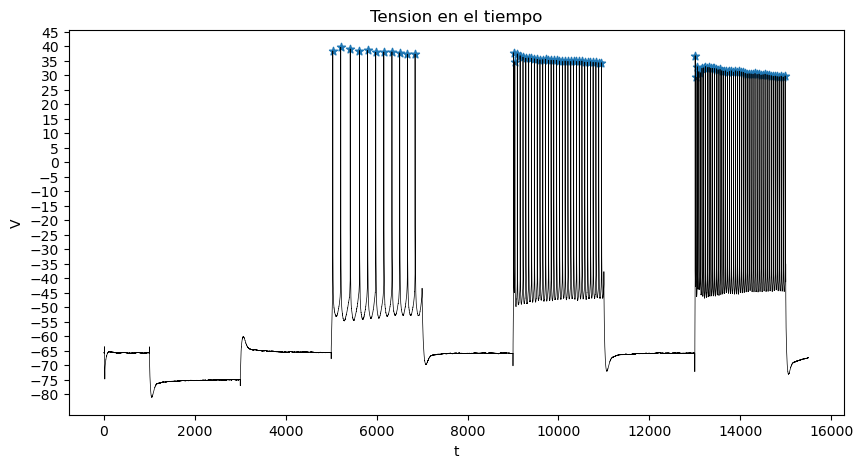

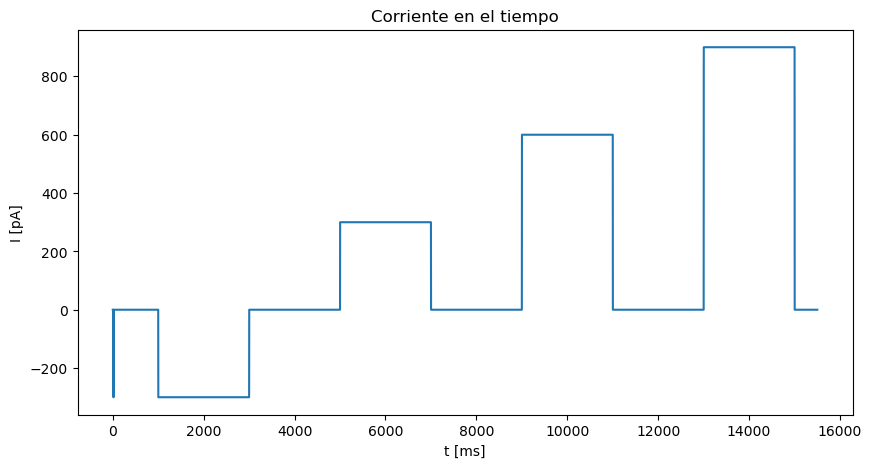

In [5]:
# graficamos
spike_times, training_peaks_h = find_peaks(v_train, height=0)
plt.figure(figsize=(10, 5))
plt.plot(t/ms, v_train, "k-", linewidth=0.5)
plt.scatter(spike_times / (fs * ms), v_train[spike_times], marker="*")
plt.xlabel('t')
plt.ylabel('V')
plt.title('Tension en el tiempo')
plt.yticks(np.arange(-80, 50, 5))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t/ms, I_train/pA)
plt.xlabel('t [ms]')
plt.ylabel('I [pA]')
plt.title('Corriente en el tiempo')
plt.show()

En primera instancia, vamos a ajustar un modelo AdEx, implementado en el módulo adex.py del paquete neuron_models

In [17]:
adex = Adex_model(V_reset = -50*mV,
                  V_thres = -35*mV,
                  V_postreset = 40*mV,
                  b = 300*pA,
                  V_rest = -65*mV,
                  delta_T = 1.0*mV)

adex.fit_spikes(t,
                spike_times,
                I_train,
                n_per_bin=len(t)//10,
                tweak_keys=['a', 'b', 'delta_T', 'tau_m', 'tau_w', 'R'],
                tweak_units=[nS, pA, mV, ms, ms, Mohm],
                N_iter=100,
                max_rep=15,
                pop_size=30,
                mut_rate=0.3,
                mut_scale=5)


C:\Users\gonza\Documents\ITBA\2024 1C\NEUROCIENCIA COMPUTACIONAL\Trabajo Final\neuron_models\adex.py:61: RuntimeWarning: overflow encountered in exp
  du = -(u - s.V_rest) + s.delta_T*np.exp((u - s.V_rh)/s.delta_T) - s.R*w + s.R*I_val
C:\Users\gonza\Documents\ITBA\2024 1C\NEUROCIENCIA COMPUTACIONAL\Trabajo Final\neuron_models\adex.py:61: RuntimeWarning: invalid value encountered in scalar add
  du = -(u - s.V_rest) + s.delta_T*np.exp((u - s.V_rh)/s.delta_T) - s.R*w + s.R*I_val


Generation 0: Best Fitness = 5.4645e-03 Params: [-1.825508, 299.569684, 1.824007, 5.905071, 100.856490, 500.045821]


KeyboardInterrupt: 

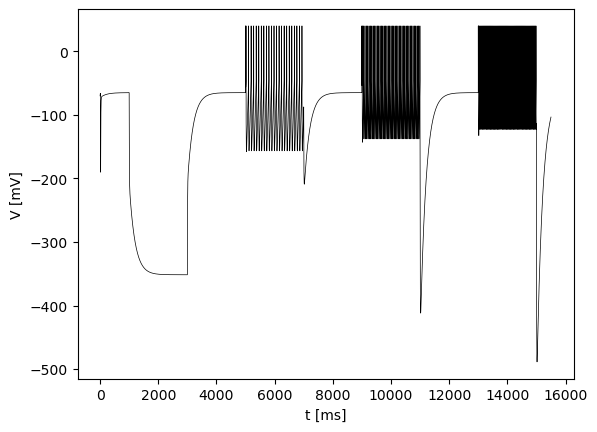

In [18]:
X, sim_spikes = adex.simulate_trajectory(t, I_train, plot=True)

Si bien pudimos modelar la dinamica de los spike trains como tenia la data original no pudimos representar correctamente la magnitud de los mismos. Los picos no superan los 0mV cuando en realidad miden 35 mV, ademas tenes picos negativos de -400mV y -500mV que no aparecen en la data original.

Aun asi el modelo represento bien en que momento ocurren los spike trains, aunque todavia requiere ajustes

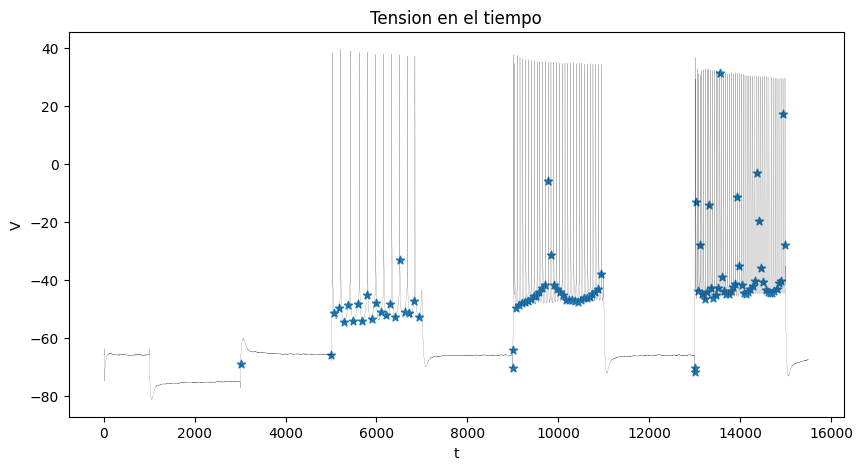

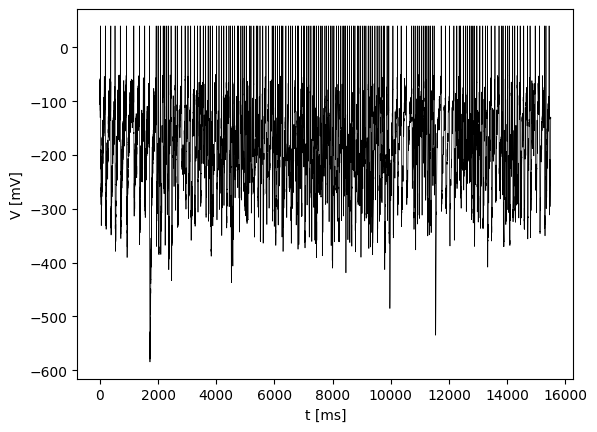

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(t/ms,v_train, "k-", linewidth=0.1)
plt.scatter(np.array(sim_spikes)/(fs*ms),v_train[sim_spikes],marker="*")
plt.xlabel('t')
plt.ylabel('V')
plt.title('Tension en el tiempo')
plt.show()
X,sim_spikes = adex.simulate_trajectory(t, I_test, plot=True)


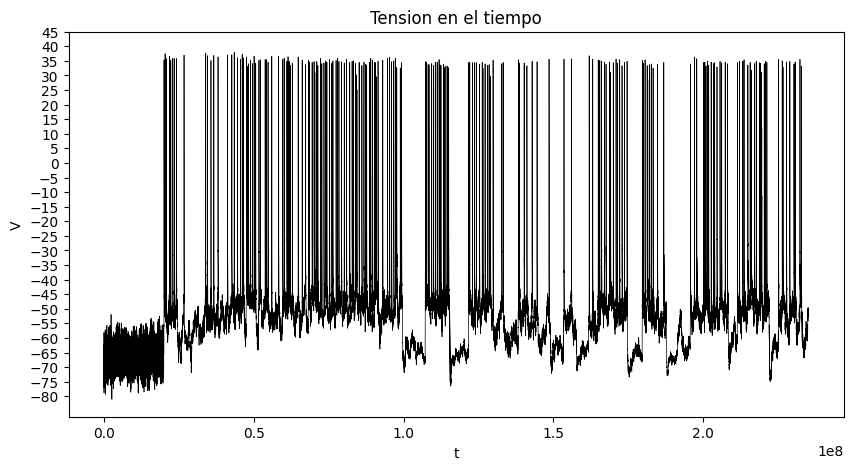

In [ ]:
# graficamos
t = np.arange(0,len(v_test),1)
plt.figure(figsize=(10, 5))
plt.plot(t/ms, v_test, "k-", linewidth=0.5)
plt.xlabel('t')
plt.ylabel('V')
plt.title('Tension en el tiempo')
plt.yticks(np.arange(-80, 50, 5))
plt.show()

In [ ]:
print(len(v_test))

235000


In [50]:
X,sim_spikes = adex.simulate_trajectory(t, I_train, plot=True)

c:\Users\Juan Bautista\.vscode\Tp Final Neuro\Neuro-16-82\Trabajo Final\neuron_models\adex.py:67: RuntimeWarning: overflow encountered in scalar divide
  return np.array([du/s.tau_m, dw/s.tau_w])
c:\Users\Juan Bautista\.vscode\Tp Final Neuro\Neuro-16-82\Trabajo Final\neuron_models\adex.py:102: RuntimeWarning: invalid value encountered in add
  X_next = X_prev + self.derivative(I_input[i-1], X_prev[0], X_prev[1])*dt


IndexError: index 155000 is out of bounds for axis 0 with size 155000

A continuación, se ajustará un modelo LIF

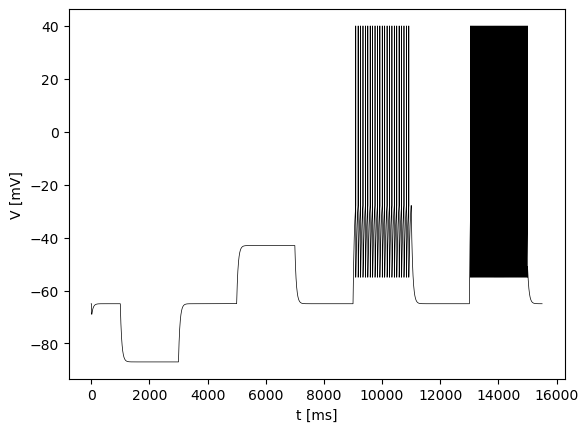

In [22]:
with open('pars_fit_juanba.json') as file:
    lif_kwargs = json.load(file)

lif = LIF_model(**lif_kwargs)
lif.simulate_trajectory(t, I_train, plot=True);

In [23]:
lif.fit_spikes(t,
              spike_times,
              I_train,
              n_per_bin=len(t)//8,
              tweak_keys=['tau_m', 'g_L', 'V_th'],
              tweak_units=[ms, nS, mV],
              N_iter=100,
              max_rep=2,
              pop_size=30,
              mut_rate=0.3)

Generation 0: Best Fitness = 0.00625 Params: [50.412727, 13.832902, -27.628329]
Generation 1: Best Fitness = 0.006535947712418301 Params: [53.801755, 13.328557, -28.132674]
Generation 2: Best Fitness = 0.006535947712418301 Params: [53.801755, 13.328557, -28.132674]
Generation 3: Best Fitness = 0.006711409395973154 Params: [50.687599, 13.730479, -27.730752]
Generation 4: Best Fitness = 0.006711409395973154 Params: [50.687599, 13.730479, -27.730752]
Generation 5: Best Fitness = 0.006711409395973154 Params: [50.687599, 13.730479, -27.730752]
No more evolution


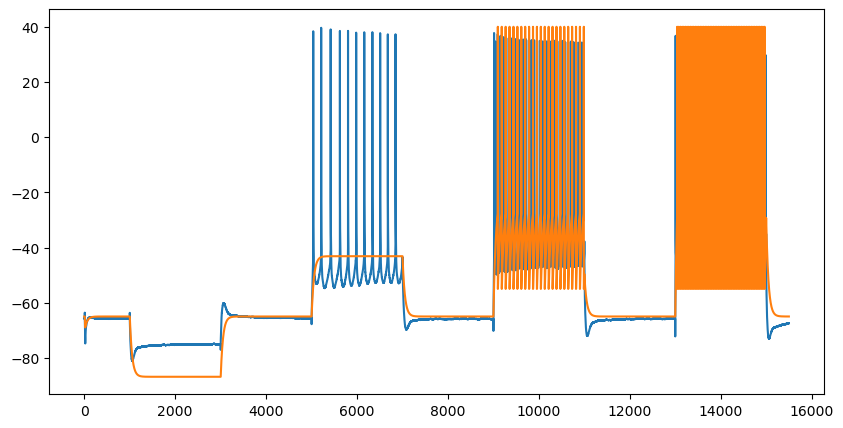

In [24]:
fit_v_lif, spikes_LIF_2 = lif.simulate_trajectory(t, I_train, plot=False)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t/ms, v_train)
ax.plot(t/ms, fit_v_lif/mV)
plt.show()

Procedemos a comparar los firing rates:

In [25]:
rates_lif = firing_rate(t, spikes_LIF_2, n_per_bin=len(t)//10)
rates_obj = firing_rate(t, spike_times, n_per_bin=len(t)//10)
np.vstack((rates_lif, rates_obj))

array([[ 0,  0,  0,  0,  0,  3, 18,  2, 25, 29],
       [ 0,  0,  0,  7,  4,  6, 25,  2, 25, 24]], dtype=int64)

Este modelo ajusta muy bien los últimos picos, pero falla al predecir los primeros. Lo guardamos con json

In [27]:
with open('pars_fit_LIF.json', 'w') as f:
    json.dump(lif.__dict__, f)